In [408]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [409]:
from IPython.core.display import display, HTML
display(HTML("<style>.scroll_box { height:10**4em  !important; }</style>"))

In [410]:
# loading data
data = pd.read_csv(
    "/Users/yamadaikuya/Desktop/Research/Codes/Ethiopia/csv/interactions.csv",
    )

#data = pd.read_csv(
#    "/Users/yamadaikuya/Desktop/Research/Codes/Ethiopia/csv/pruned.csv",
#    )

In [411]:
data = data.dropna(subset=['Age', 'female', 'Years_of_Schooling', 'Math_Score',
       'parents_are_farmers', 'born_in_this_village', 'Risk_averse',
       'Competitive', 'Absolute_Overconfidence', 'Relative_Overconfidence', "Cut_Flower"])

In [412]:
data = data.drop(['type_', 'ln_workers_income_bf', 'ln_workers_income_cu',
       'save_rate'], axis=1)

In [413]:
# dataframe -> numpy.array
Y = data.loc[:, ["Cut_Flower"]].values
X = data.drop(["Cut_Flower"], axis=1).values
print(X.shape, Y.shape)

(289, 55) (289, 1)


In [414]:
# normalization
def normalize(x):
    xmean = x.mean(axis=0, keepdims=True)
    xstd = np.std(x, axis=0, keepdims=True)
    zscore = (x - xmean) / xstd
    return zscore

In [415]:
X = normalize(X)

In [416]:
# n_x, n_y = nbr of variables
def create_placeholders(n_x, n_y):
    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None])
    return X, Y

In [430]:
# Initializing the parameters 
# Determin the shape of hidden layers
def initialize_parameters():
    
    tf.set_random_seed(198)
    
    W1 = tf.get_variable("W1", [32, 55], initializer=tf.initializers.he_normal(seed=198))
    b1 = tf.get_variable("b1", [32, 1], initializer=tf.zeros_initializer())
    W_ = tf.get_variable("W_", [16, 32], initializer=tf.initializers.he_normal(seed=198))
    b_ = tf.get_variable("b_", [16, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [1, 16], initializer=tf.initializers.he_normal(seed=198))
    b2 = tf.get_variable("b2", [1, 1], initializer=tf.zeros_initializer())
    
    parameters={
        "W1": W1,
        "b1": b1,
        "W_": W_,
        "b_": b_,
        "W2": W2,
        "b2": b2
    }
    
    return parameters

In [418]:
def forward_propagation(X, parameters):
    # retrieve parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W_ = parameters['W_']
    b_ = parameters['b_']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)  
    Z_ = tf.add(tf.matmul(W_, A1), b_)
    A_ = tf.nn.relu(Z_)
    Z2 = tf.add(tf.matmul(W2, A_), b2)
    
    return Z2

In [419]:
def compute_cost(Z2, Y):
    logits = tf.transpose(Z2)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [420]:
def l2(W1, W_, W2, lamda=0.01):
    return lamda*(tf.nn.l2_loss(W1) + tf.nn.l2_loss(W_) + tf.nn.l2_loss(W2))

In [433]:
# check the behavior
tf.reset_default_graph()
sess = tf.Session()
a, b = create_placeholders(55, 1)
parameters = initialize_parameters()
Z3 = forward_propagation(a, parameters)
cost = compute_cost(Z3, b)
print("Z2 = {}".format(str(Z3)))
print("cost = {}".format(str(cost)))

Z2 = Tensor("Add_2:0", shape=(1, ?), dtype=float32)
cost = Tensor("Mean:0", shape=(), dtype=float32)


In [422]:
# Divide dataset 
def dividing(X, Y, seed=198, test_size=0.3):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size = test_size, random_state=seed
        )
    return X_train.T, Y_train.T, X_test.T, Y_test.T

In [423]:
# createing mini batches
import random
def create_minibatch(X, Y, batch_size, seed=198):
    random.seed(seed)
    X_batch = []
    Y_batch = []
    _ = [i for i in range(X.shape[1])]
    random.shuffle(_)
    X = X[:, _]
    Y = Y[:, _]
    num = X.shape[1] // batch_size
    for i in range(num):
        X_batch.append(X[:, i*num : i*num + batch_size])
        Y_batch.append(Y[:, i*num : i*num + batch_size])
    X_batch.append(X[:, num*batch_size : ])
    Y_batch.append(Y[:, num*batch_size : ])
    return X_batch, Y_batch, num+1

In [474]:
# model with minibatch
def mini_batch_model(X_train, Y_train, X_test, Y_test, num_epochs, lamda, learning_rate = 0.001, print_cost = True):
    ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables    
    tf.set_random_seed(1)
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []    
    costs_test = []
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    W1= parameters["W1"]
    W_ = parameters["W_"]
    W2 = parameters["W2"]
    cost = compute_cost(Z3, Y)
    L2 = l2(W1, W_, W2, lamda=lamda)
    cost = cost + L2
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.round(tf.sigmoid(Z3)), Y)
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    flag = False
    
    for epoch in tqdm(range(num_epochs+1)):
        x, y, num = create_minibatch(X_train, Y_train, batch_size=32, seed=np.random.randint(10**4))
        epoch_cost = 0
        for i, k in zip(x, y):
            
            _, c = sess.run([optimizer, cost], feed_dict={X: i, Y: k})
            epoch_cost += c / num
        
        if epoch % 2000 == 0 and print_cost==True:
            print("Cost after epoch %i: %f"%(epoch, epoch_cost))
        if epoch % 10 == 0:
            epoch_cost_test = sess.run(cost, feed_dict={X: X_test, Y: Y_test})
            if len(costs_test) > 1  and epoch_cost_test > np.squeeze(costs_test)[-1] \
            and np.squeeze(costs_test)[-2] > np.squeeze(costs_test)[-1]:
                flag = True
                print("Early Stop!!")
                break
            costs.append(epoch_cost)
            costs_test.append(epoch_cost_test)
        if flag:
            break
    # plot the cost
    plt.plot(np.squeeze(costs), c="blue")
    plt.plot(np.squeeze(costs_test), c="orange")
    plt.ylabel('cost')
    plt.xlabel('epoches (per tens)')
    plt.title("Learning rate = {}\nlambda ={}".format(str(learning_rate), str(lamda)))
    plt.show()
    
    # lets save the parameters in a variable
    parameters = sess.run(parameters)
    print ("Parameters have been trained!")
    
    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}, session=sess))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}, session=sess))
    
    output = tf.sigmoid(Z3)

    return parameters, output

Early Stop!!


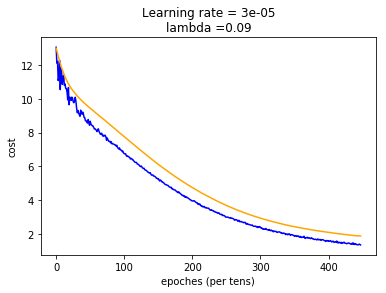

Parameters have been trained!
Train Accuracy: 0.9027778
Test Accuracy: 0.55172414


Early Stop!!


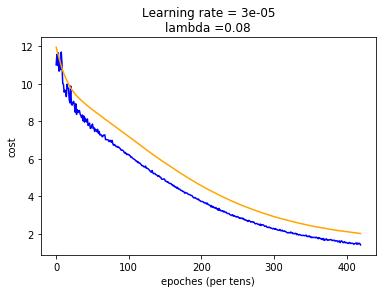

Parameters have been trained!
Train Accuracy: 0.9166667
Test Accuracy: 0.55172414


Early Stop!!


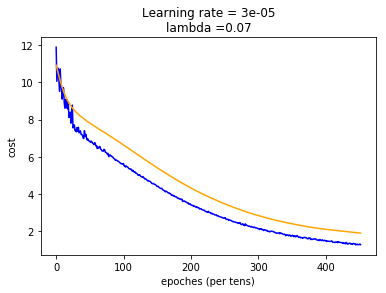

Parameters have been trained!
Train Accuracy: 0.9027778
Test Accuracy: 0.537931


In [476]:
X_train, Y_train, X_test, Y_test = dividing(X, Y, seed=198, test_size=0.5)
for i,k,m in zip(
    [0.09, 0.08, 0.07], [0.00003]*3, [10000, 10000, 10000]
    ):
            parameters, output = mini_batch_model(X_train, Y_train, X_test, Y_test, num_epochs=m,
                                      lamda=i, learning_rate=k, print_cost=False)

In [468]:
s = tf.Session()
init = tf.global_variables_initializer()
s.run(init)
s.run(output, feed_dict={: X})

NameError: name 'n_x' is not defined

In [ ]:
import requests

class LineNotifyAPI:

    url = "https://notify-api.line.me/api/notify"

    def __init__(self, access_token):
        self.__headers = {'Authorization': 'Bearer ' + access_token}

    def send(self, message, image=None, stickerPackageId=None, stickerId=None):
        payload = {
        'message': message,
        "stickerPackageId": stickerPackageId,
        "stickerId": stickerId,
        }
        files={}
        if image != None:
            files = {"imageFile": open(image, "rb")}
        r = requests.post(
            url=LineNotifyAPI.url,
            headers=self.__headers,
            data=payload,
            files=files,
            )
#from Notify_bot import LineNotifyAPI
tome_token = 'eemHbY4riW0drjOwx9x2drcjszNEWM2mrbtWWXiIICs' 
bot = LineNotifyAPI(access_token=tome_token)
bot.send(
    message="Finished!",
    #image="/Users/yamadaikuya/Desktop/cat.png",
    stickerPackageId=1, 
    stickerId=10
    )